<a href="https://colab.research.google.com/github/btahir/Deep-Cropper/blob/master/deep_cropper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Cropper

Notebook inspired by this [tweet](https://twitter.com/chriseberly/status/1143215509640548360).

Let's do some photoshopping using Deep Learning! 

In this notebook we will crop an object (person, animal etc.) out of an image and place it on another. 

Just for fun, let's put a Polar Bear next to Jeff Goldblum.

In [0]:
# import model
import torch
from IPython.display import clear_output

model = torch.hub.load('pytorch/vision', 'deeplabv3_resnet101', pretrained=True)
model.eval()

clear_output()

In [0]:
# import packages
import urllib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
from PIL import Image
from torchvision import transforms
%matplotlib inline

In [0]:
# make working directory
mkdir work

Let's download the images for our task.

Foreground image is the one you want to crop an object out of and background image is the image you want to overlay/paste it on.

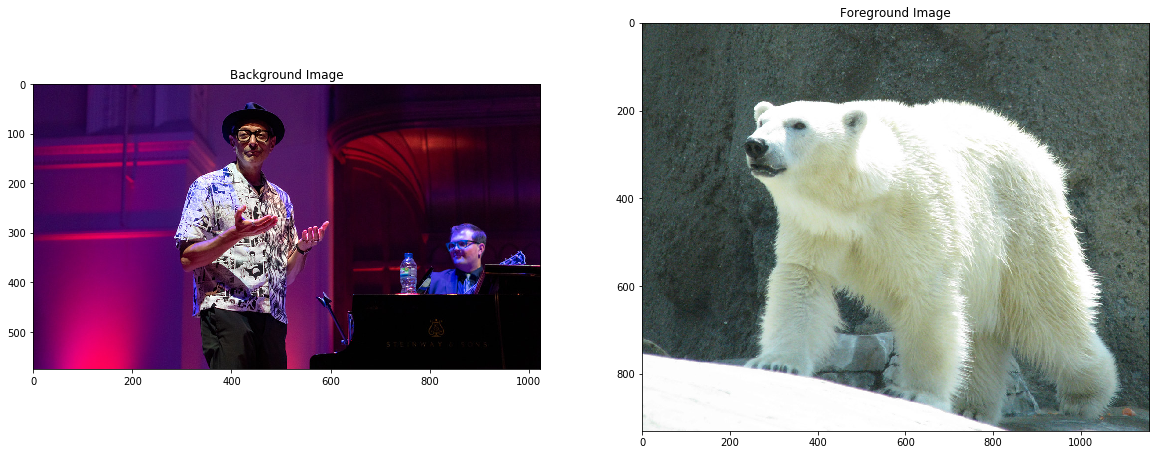

In [4]:
#@title Filename Paths For Foreground and Background Images:
FOREGROUND = 'https://live.staticflickr.com/1399/1118093174_8b723e1ee5_o.jpg' #@param {type:"string"}
BACKGROUND = 'https://live.staticflickr.com/7860/46618564664_be235e82e8_b.jpg' #@param {type:"string"}

# get background
url, filename = (BACKGROUND, "work/background.jpg")

try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
  
background = Image.open(filename).convert("RGB")
background.save('work/background.jpg')

# get foreground
url, filename = (FOREGROUND, "work/foreground.jpg")

try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
  
foreground = Image.open(filename).convert("RGB")
foreground.save('work/foreground.jpg')

# plot
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(121)
ax1.imshow(background)
ax2 = fig.add_subplot(122)
ax2.imshow(foreground)

ax1.title.set_text('Background Image')
ax2.title.set_text('Foreground Image')


Now we have to do some image processing. 

Let's start by Segmenting the foreground image aka getting a mask of the object.

In [0]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(foreground)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

In [6]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(foreground.size)
r.putpalette(colors)
bw = r.convert('L')
bw.save('work/mask.png')

# crop out object
src1 = cv2.imread('work/foreground.jpg')
src1_mask = cv2.imread('work/mask.png')
ret,thresh1  = cv2.threshold(src1_mask,30,255,cv2.THRESH_BINARY)
src1 = cv2.cvtColor(src1,cv2.COLOR_RGB2BGR)
src1_mask = cv2.cvtColor(thresh1,cv2.COLOR_RGB2BGR)

mask_out=cv2.subtract(src1_mask,src1)
mask_out=cv2.subtract(src1_mask,mask_out)
cv2.imwrite('work/foreground.jpg',cv2.cvtColor(mask_out, cv2.COLOR_RGB2BGR))

# create mask
src = cv2.imread('work/mask.png', 1)
tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
thr,alpha = cv2.threshold(tmp,30,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(src)
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)
cv2.imwrite("work/mask.png", dst)

True

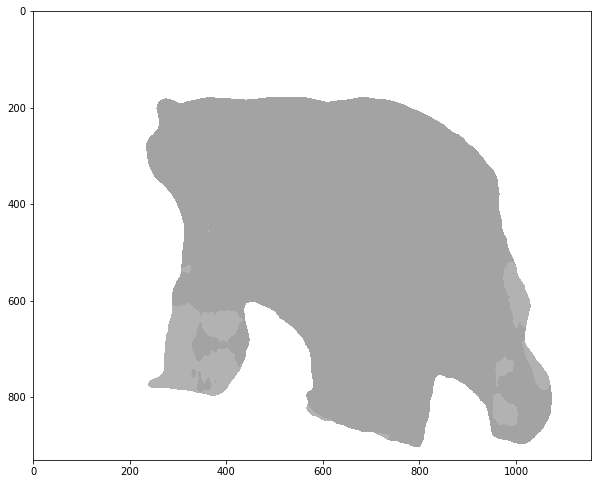

In [7]:
# mask generated
plt.figure(figsize=(10, 10))
plt.imshow(dst)

And merge the cropped out image over the background image. You can play with the parameters on the left to resize the images and adjust the position of the mask (where it will be placed).

In [8]:
#@title Image Parameters
#@markdown ### Background Image Size:
BACKGROUND_HEIGHT = 512 #@param {type:"integer"}
BACKGROUND_WIDTH = 1024 #@param {type:"integer"}
#@markdown ### Foreground Image Size:
FOREGROUND_HEIGHT = 512 #@param {type:"integer"}
FOREGROUND_WIDTH = 512 #@param {type:"integer"}

def f(x,y):
  fig = plt.figure(figsize=(20, 20))

  ax1 = fig.add_subplot(111)
  background = Image.open('work/background.jpg')
  background = background.resize((BACKGROUND_WIDTH,BACKGROUND_HEIGHT))
  mouse = Image.open('work/foreground.jpg')
  mouse = mouse.resize((FOREGROUND_WIDTH,FOREGROUND_HEIGHT))
  mouse_mask = Image.open('work/mask.png')
  mouse_mask = mouse_mask.resize((FOREGROUND_WIDTH,FOREGROUND_HEIGHT))

  background.paste(mouse, (x,y), mouse_mask)
  background.save('output.jpg')
  ax1.set_title('Output Image')
  plt.imshow(background)

h, w = background.size
print('Use these x,y sliders to adjust Foreground Image Placement\n')

interactive_plot = interactive(f, x=(-h, h, 10), y=(-w, w, 10))
output = interactive_plot.children[-1]
interactive_plot

Use these x,y sliders to adjust Foreground Image Placement



interactive(children=(IntSlider(value=-4, description='x', max=1024, min=-1024, step=10), IntSlider(value=-6, …

And we get Jeff Goldblum with a Polar bear! 

Image is saved as output.jpg if you want to download it.